### This notebook fits a BERTopic model to the data set and creates topic visualisations.
##### (using the data set with short tweets removed)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [130]:
# Run these two lines to have all plots appear on GitHub (do not run to use interactive plots within this notebook):
import plotly.io as pio

pio.renderers.default = "png"

In [2]:
# Set directory and file paths
READ_DIR = "../data/processed"

FILENAME = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_3wordtweetdrop"

EMBEDDING_MPNET = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_3wordtweetdrop_all-mpnet-base-v2.npy"

In [3]:
# Load embeddings
embeddings_mpnet = np.load(f"{READ_DIR}/{EMBEDDING_MPNET}")

In [4]:
# Load text data
df = pd.read_csv(f"{READ_DIR}/{FILENAME}.csv")

#### Set customisable parameters for BERTopic components:

In [5]:
# Parameters for UMAP
n_neighbors = 15
n_components = 5
min_dist = 0.1
metric_umap = "cosine"
random_state = 0

# UMAP model
reducer = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Parameters for HDBScan
min_cluster_size = 15
min_samples = 5
metric_hdbscan = "euclidean"
cluster_selection_method = "eom"

# HDBScan model
clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric=metric_hdbscan,
    cluster_selection_method=cluster_selection_method,
    prediction_data=True,
)

# The lower and upper boundary of the range of n-values for different word n-grams
# or char n-grams to be extracted:
ngram_range = (1, 2)

#### Create functions to fit BERTopic model:

In [112]:
def get_bertmodel(ngram_range, umap_model, hdbscan_model):
    # Convert a collection of text documents to a matrix of token counts:
    vectorizer = CountVectorizer(
        stop_words=stopwords.words("english"),
        tokenizer=TweetTokenizer().tokenize,
        token_pattern=None,
        ngram_range=ngram_range,
    )

    # Fit BERTopic model with customisation:
    topic_model = BERTopic(
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
    )

    return topic_model


def get_topics_probs(model, docs, embeddings):
    topics, probs = model.fit_transform(docs, embeddings=embeddings)
    return topics, probs


def fit_bert(docs, embeddings, ngram_range, umap_model, hdbscan_model):
    bertmodel = get_bertmodel(
        ngram_range=ngram_range, umap_model=umap_model, hdbscan_model=hdbscan_model
    )

    topics, probs = get_topics_probs(model=bertmodel, docs=docs, embeddings=embeddings)

    return bertmodel, topics, probs

#### Fit BERTopic model using MPNET embeddings:

In [26]:
bertmodel_mpnet, topics_mpnet, probs_mpnet = fit_bert(
    docs=list(df.clean_text),
    embeddings=embeddings_mpnet,
    ngram_range=ngram_range,
    umap_model=reducer,
    hdbscan_model=clusterer,
)

##### Display the results table:
note: Topic -1 represents outliers 

In [7]:
df_bertopics_mpnet = bertmodel_mpnet.get_topic_info()
print("Number of topics: {}".format(len(df_bertopics_mpnet)))
df_bertopics_mpnet["Percentage"] = round(
    df_bertopics_mpnet["Count"] / df_bertopics_mpnet["Count"].sum() * 100, 2
)
df_bertopics_mpnet

Number of topics: 115


,Topic,Count,Name,Representation,Representative_Docs,Percentage
0,-1,7021,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, us, im, plane...",[i hope it takes you 6 hours to get home when ...,50.68
1,0,1023,0_bag_bags_luggage_baggage,"[bag, bags, luggage, baggage, lost, claim, lef...",[on top or having to check my bag I had to wai...,7.38
2,1,404,1_hold_call_minutes_phone,"[hold, call, minutes, phone, hours, hung, hour...","[2 hours on hold. Still no answer. Horrible., ...",2.92
3,2,267,2_great_crew_attendant_awesome,"[great, crew, attendant, awesome, great flight...","[great flight! Great view!:-), Another great f...",1.93
4,3,218,3_gate_sitting_plane_crew,"[gate, sitting, plane, crew, minutes, hour, ta...",[hey flight 5350 in dfw stuck at gate with no ...,1.57
...,...,...,...,...,...,...
110,109,15,109_departs enroute_enroute_departs_following ...,"[departs enroute, enroute, departs, following ...","[Flight 4968 (N8325D) departs enroute to, Flig...",0.11
111,110,15,110_year old_5 year_sit_old,"[year old, 5 year, sit, old, guy, old flight, ...",[a 5 year old can't sit alone on a flight. Thi...,0.11
112,111,15,111_worries_straight_funny_much settled,"[worries, straight, funny, much settled, ones ...",[ok no worries. Thanks for the straight story....,0.11
113,112,15,112_confirmation_confirmation code_confirmatio...,"[confirmation, confirmation code, confirmation...","[not able to DM you my confirmation number, "":...",0.11


#### Choose a topic number and print data from the corresponding row:

In [13]:
topic_num = 0
for i, v in df_bertopics_mpnet.iloc[topic_num + 1].items():
    print(f"{i} : {v}")

Topic : 0
Count : 1023
Name : 0_bag_bags_luggage_baggage
Representation : ['bag', 'bags', 'luggage', 'baggage', 'lost', 'claim', 'left', 'checked', 'carry', 'baggage claim']
Representative_Docs : ['on top or having to check my bag I had to wait over 30 min for my bag to come out at baggage claim. Thanks for wasting my time', 'where are my bags?', 'WHERE IS MY BAG?!?!?!']
Percentage : 7.38


#### Show topic words and c-TF-IDF scores:

In [9]:
bertmodel_mpnet.get_topic(0)

[('bag', 0.03239210137969543),
 ('bags', 0.021546903046430456),
 ('luggage', 0.021387434182909032),
 ('baggage', 0.0182538419241516),
 ('lost', 0.014626736394153721),
 ('claim', 0.008993452876973182),
 ('left', 0.007821801642699598),
 ('checked', 0.007272552349602147),
 ('carry', 0.006689635642223286),
 ('baggage claim', 0.0065415167894751405)]

##### For each topic, we can observe the most important words, sorted in decreasing order based on the c-TF-IDF score:

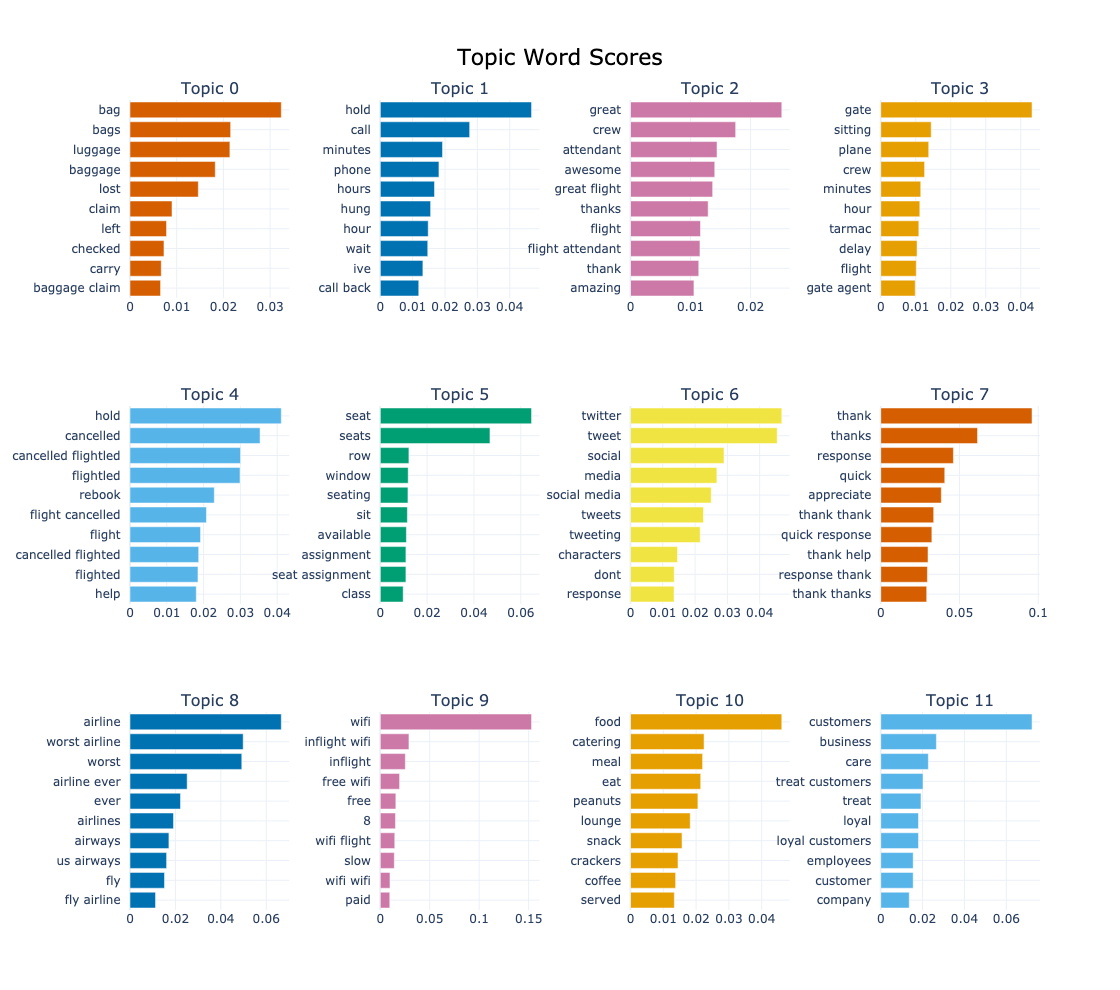

In [41]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, top_n_topics=12, n_words=10
)
barchart.show()

### Looking at sample of outliers:

In [8]:
df_topics = pd.DataFrame(
    {"Document": df["clean_text"], "Topic": bertmodel_mpnet.topics_}
)

outlier_tweets = df_topics["Document"][df_topics["Topic"] == -1]

[print(tweet) for tweet in outlier_tweets.sample(15, random_state=11)]

that would be lovely! You have great people working in your organization.
This is absurd. Should a stranger help my kids if there's a problem?
Your survey is too long. I fly a lot of segments and I'll fill it out after every trip, but not if it takes more than a minute.
I have 2d and 3d embossed badges and patches superior to the ones you are currently using.
Why close prechk at 8PM on a Sunday at JFK?
Never got to the strip that fast before. Stoked for special show tonight! Thx again!
Thanks for the FB. message telling me I will have to wait between 1-3 days. I'm waiting.
weather delays > next few weeks ;)
I'd rather spend two days in the back seat of a Volkswagen than two hours on your plane!
does it look like to we talked to customer service?
Its poor Flight management. There is no reason why a scheduled 8:00 pm flight to takr off At 11:00pm.
diverted and missed our connecting flight. Was just told that my bag is on it's way to MSY. If you only had people that cared
Yep. 1 hour at L

### Where are the tweets about delays?

In [9]:
df_topics["Topic"][df_topics["Document"].str.contains("delay")].value_counts()[:10]

Topic
-1     511
 27     49
 0      44
 3      42
 25     37
 81     18
 2      13
 98     10
 51     10
 17     10
Name: count, dtype: int64

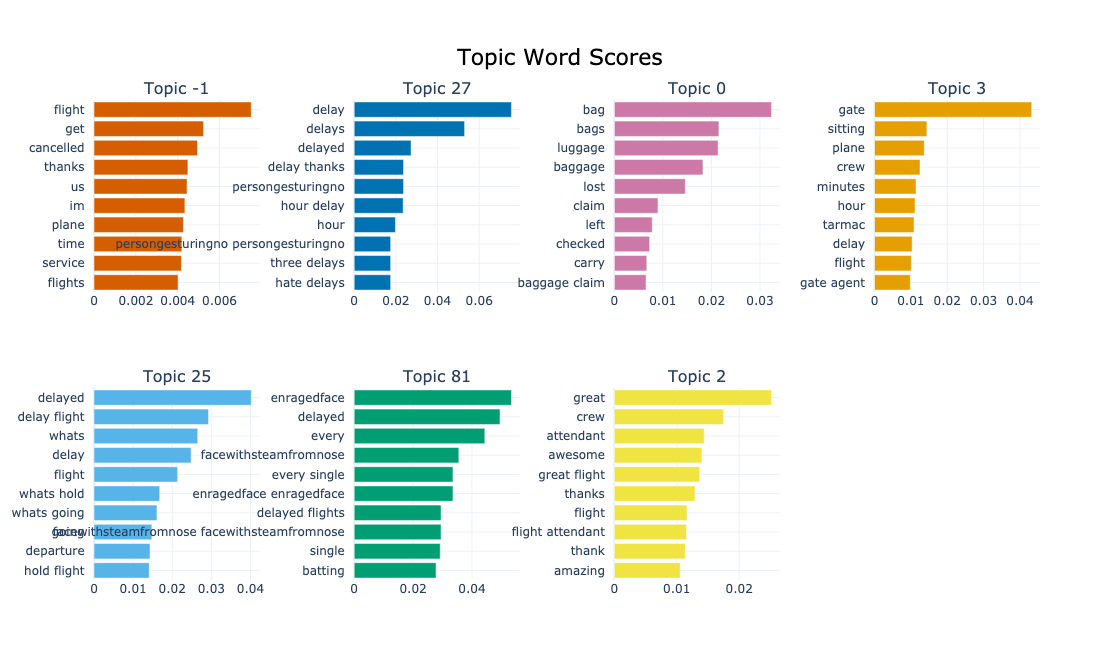

In [75]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, topics=[-1, 27, 0, 3, 25, 81, 2], n_words=10
)
barchart.show()

In [82]:
# Look at samples of the topics that appear to be most specifically about delays:
for topic in [27, 25, 81]:
    [print(t) for t in bertmodel_mpnet.get_representative_docs(topic)]
    print()

90 min delay thanks to "maintenance issues". Thanks for wasting a day.
while listening to a delay message on my phone, another delay message was coming in. Get your shit together!
it's not about the delay. It's about the communication.

this delay of flight UA4636 has been painful. I sure hope it doesn't cause me or my luggage) to miss my UA82 flight to New Delhi!
whats going on with flight 2034. Delayed beyond 834. Shouldnt thre flights switch at that point?
20 min more delays to flt 2086 at sfo 2 load 2 more pax makes no sense. Will strand many of us overnight at ORD due to missed cnxns

18 flights so far this year. 13 delays including 2 Cancelled Flightations. Late Flightst reason, crew needed mandatory sleep. IN MEXICO!
every single time i fly you guys i am delayed at least 30 minutes. Every time. On flight 5612 out of to nola.
seriously? Every flight I have had the past 2 days has been delayed. Every single one. Terrible



### Merging topics about delays:

In [83]:
topics_to_merge = [27, 25, 81]
bertmodel_mpnet.merge_topics(df["clean_text"], topics_to_merge)

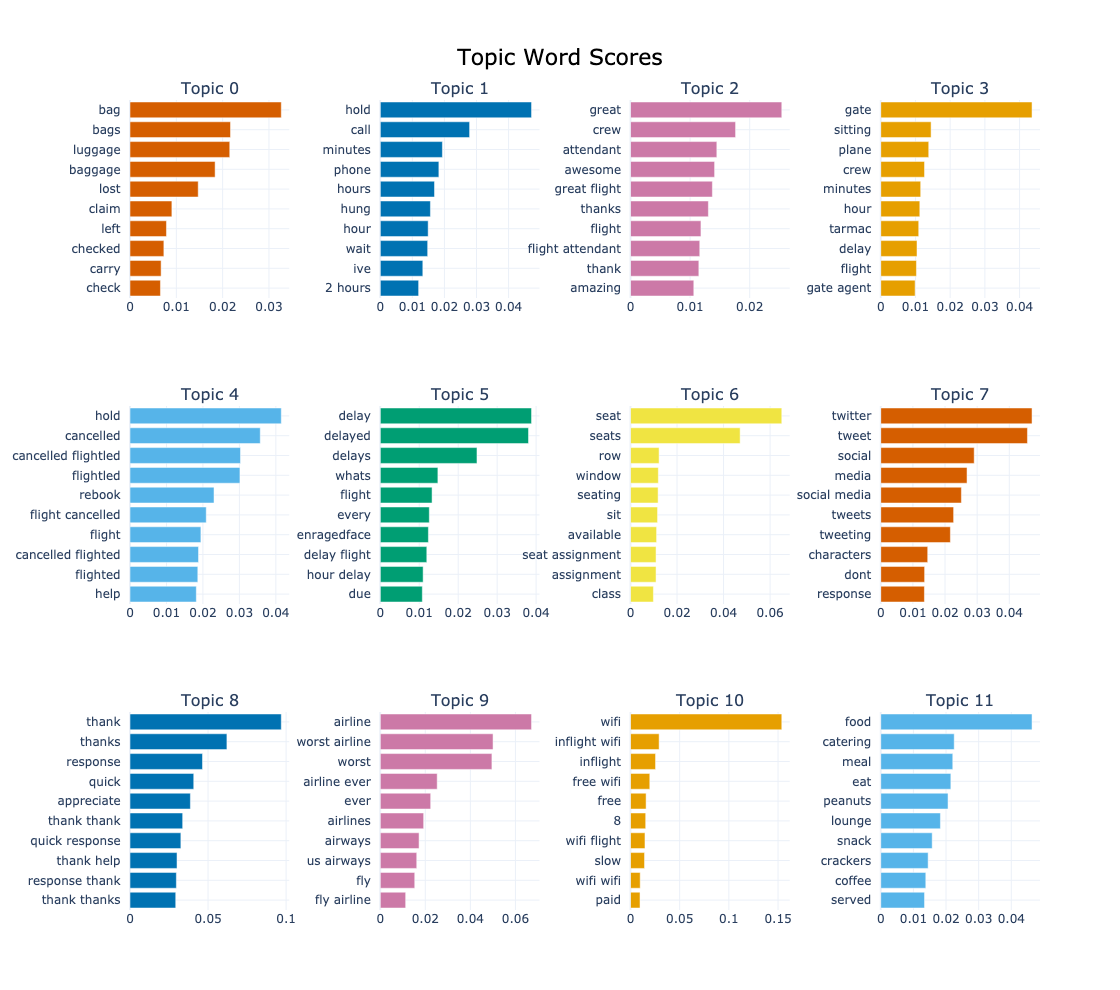

In [85]:
barchart = bertmodel_mpnet.visualize_barchart(
    width=280, height=330, top_n_topics=12, n_words=10
)
barchart.show()

#### We can also see the distribution of topics per class, i.e. per Airline in this case:

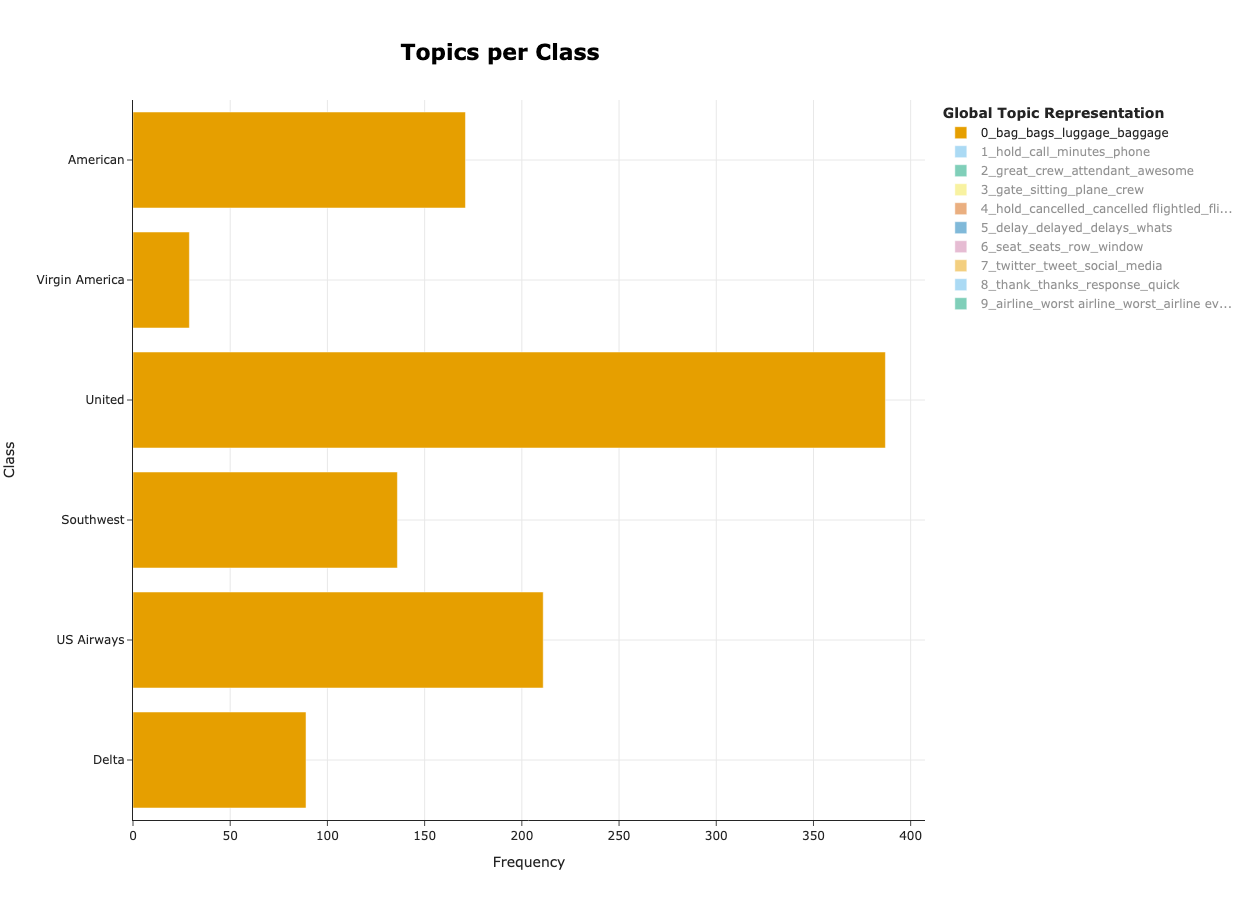

In [139]:
topics_per_class = bertmodel_mpnet.topics_per_class(
    df["clean_text"], classes=df["airline"]
)

bertmodel_mpnet.visualize_topics_per_class(
    topics_per_class, top_n_topics=10, normalize_frequency=False
)

## Look at document info table:

In [124]:
df_doc = bertmodel_mpnet.get_document_info(df["clean_text"])
df_doc["Airline"] = df["airline"]
df_doc.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,Airline
0,plus you've added commercials to the experienc...,12,12_customers_business_care_treat customers,"[customers, business, care, treat customers, t...",[needs an entire customer service overhaul wou...,customers - business - care - treat customers ...,0.454308,False,Virgin America
1,I didn't today... Must mean I need to take ano...,20,20_yes_yet_ac_would,"[yes, yet, ac, would, one, baggage, yes landed...","[Yes, it was Sunday., yes, after landing at 93...",yes - yet - ac - would - one - baggage - yes l...,0.973092,False,Virgin America
2,"it's really aggressive to blast obnoxious ""ent...",12,12_customers_business_care_treat customers,"[customers, business, care, treat customers, t...",[needs an entire customer service overhaul wou...,customers - business - care - treat customers ...,0.415210,False,Virgin America
3,and it's a really big bad thing about it,-1,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, us, im, plane...",[i hope it takes you 6 hours to get home when ...,flight - get - cancelled - thanks - us - im - ...,0.000000,False,Virgin America
4,seriously would pay $30 a flight for seats tha...,-1,-1_flight_get_cancelled_thanks,"[flight, get, cancelled, thanks, us, im, plane...",[i hope it takes you 6 hours to get home when ...,flight - get - cancelled - thanks - us - im - ...,0.000000,False,Virgin America


#### It would be useful to plot topic counts normalised by total tweets per airline, so we can see the prevalence of particular themes,<br> e.g. complaints as a fraction of total tweets:

In [126]:
# Create a dictionary to map airline to total number of tweets associated
docs_per_airline = df["airline"].value_counts().to_dict()
docs_per_airline

{'United': 3658,
 'US Airways': 2831,
 'American': 2505,
 'Southwest': 2296,
 'Delta': 2089,
 'Virgin America': 475}

In [128]:
def plot_normalised_topics(
    data: pd.DataFrame,
    topics2plot: list[str],
    groupby_cols: list[str]=["Topic", "Airline", "Name"],
    count_apply_col: str="Airline",
    label_col: str="Name",
    norm_dict: dict=docs_per_airline,
):
    """ Function to plot normalised topic counts by a certain feature, e.g. count_apply_col = Airline
    """
    df2plot = (
        data.groupby(groupby_cols)[count_apply_col].count().reset_index(name="Count")
    )
    df2plot_ = df2plot[df2plot["Topic"].isin(topics2plot)]
    df2plot_["Percentage"] = 100 * df2plot_.apply(
        lambda x: x["Count"] / norm_dict[x[count_apply_col]], axis=1
    )
    sns.barplot(df2plot_, x=count_apply_col, y="Percentage", hue=label_col).set_title(
        "Normalised topics"
    )
    plt.gcf().set_size_inches(12, 8)

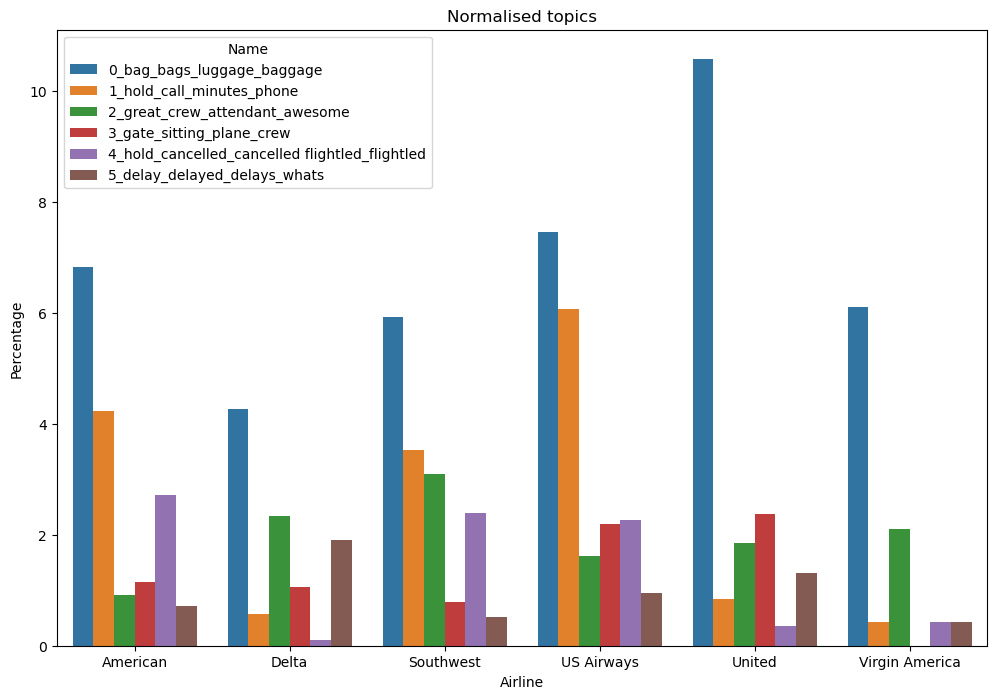

In [131]:
plot_normalised_topics(
    data=df_doc,
    topics2plot=[0, 1, 2, 3, 4, 5],
    groupby_cols=["Topic", "Airline", "Name"],
    count_apply_col="Airline",
    label_col="Name",
    norm_dict=docs_per_airline,
)

From the above, it appears that:
- United have the biggest issues related to baggage, although it's prevalent for all airlines
- American, Southwest and US Airways have siginificant issues related to being on hold on the phone
- Delta are most affected by delays
- Virgin America have no issues relating to crew

In [138]:
# Print samples of the topics from above:
for topic in [0, 1, 2, 3, 4, 5]:
    [print(f"Topic {topic}: {t}") for t in bertmodel_mpnet.get_representative_docs(topic)]
    print()

Topic 0: on top or having to check my bag I had to wait over 30 min for my bag to come out at baggage claim. Thanks for wasting my time
Topic 0: where are my bags?
Topic 0: WHERE IS MY BAG?!?!?!

Topic 1: 2 hours on hold. Still no answer. Horrible.
Topic 1: Not good. On hold for over an hour.
Topic 1: Was put on hold for 5.5 hrs then got a call back at 11:20 pm, only to wait on hold for another hour.

Topic 2: great flight! Great view!:-)
Topic 2: Another great flight & crew, Las Vegas-Chicago. Thanks!
Topic 2: Great flight, as always! Thank you to the great crew on flight 475!

Topic 3: hey flight 5350 in dfw stuck at gate with no gate agent. Plane full of people missing connections.
Topic 3: but you are Late Flight again!! Again and again! Where are the crew?
Topic 3: 40+ minutes waiting at the gate for the broken jetway. Different gate maybe?

Topic 4: we've been on hold for 2 hours trying to reschedule our Cancelled Flightled flight. Can anyone out there please help us?
Topic 4: fl

#### Create a 2D representation of the topics:

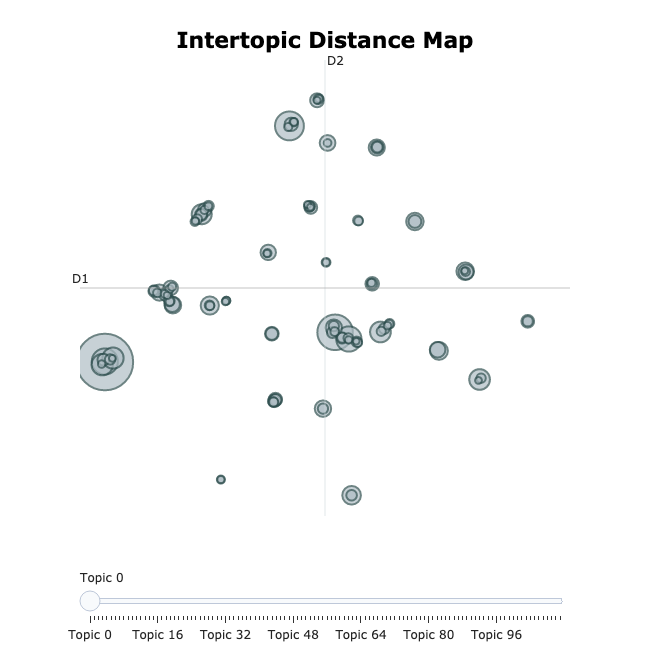

In [86]:
distance_map = bertmodel_mpnet.visualize_topics()
distance_map.show()

#### Visualise topic similarity with a heatmap:

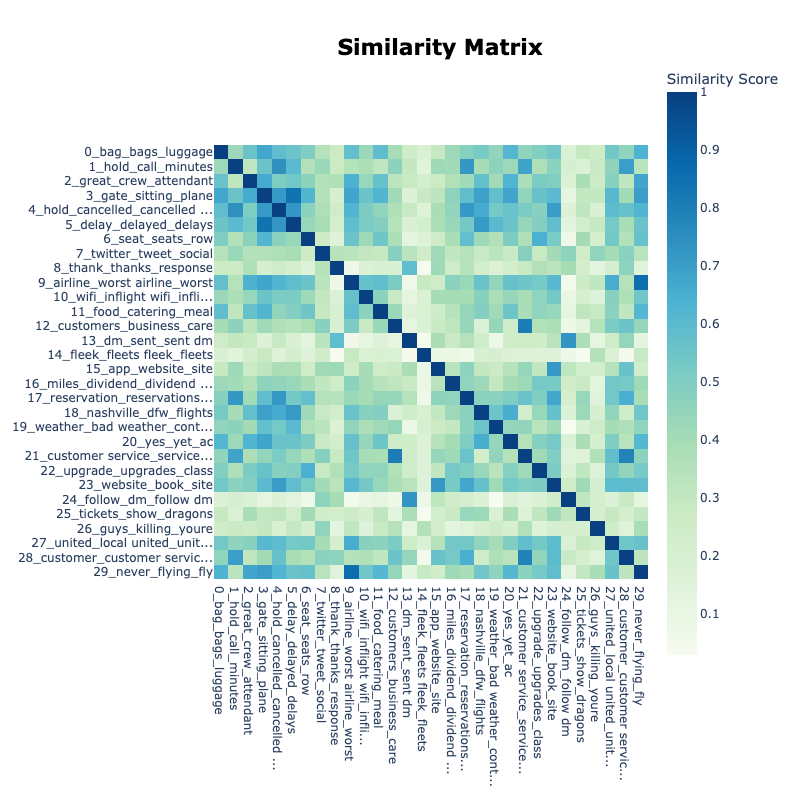

In [89]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(top_n_topics=30)
similarity_matrix.show()

#### We can also specify a number of clusters before creating the similarity matrix. Similar themes are then grouped together:

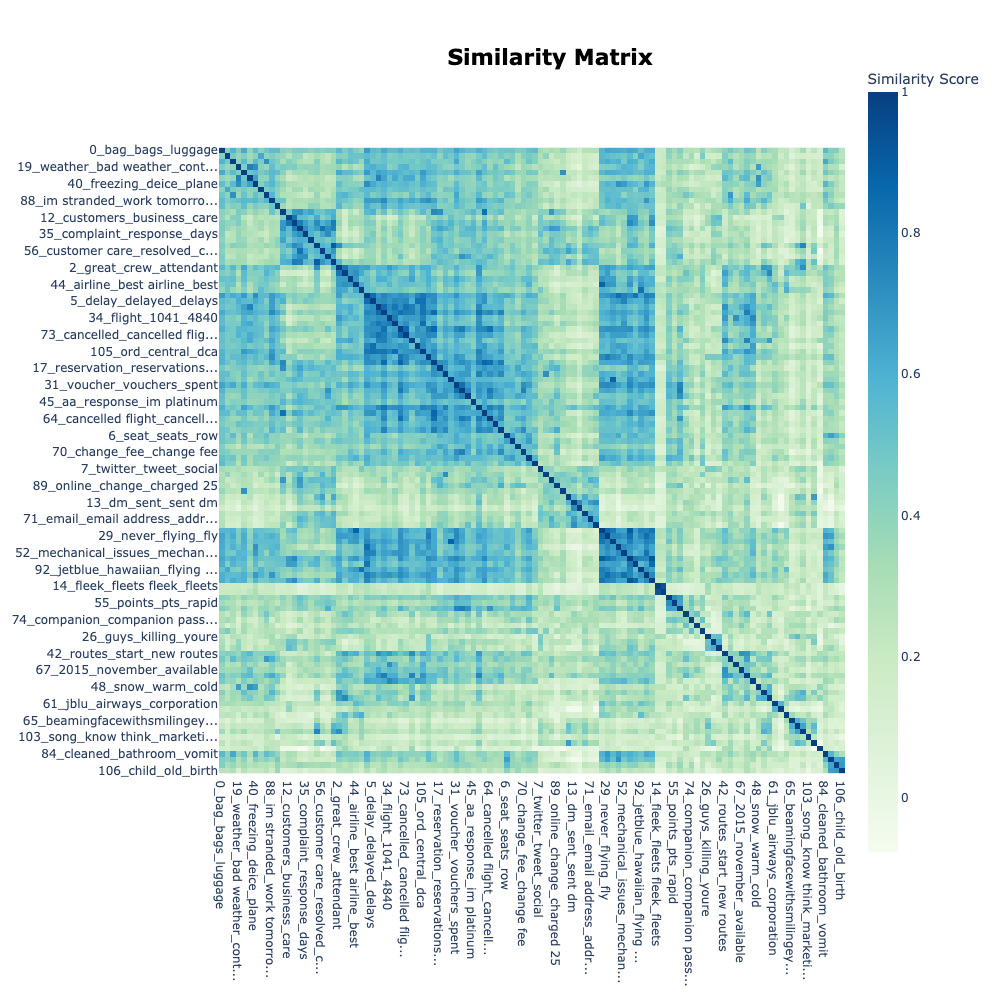

In [90]:
similarity_matrix = bertmodel_mpnet.visualize_heatmap(
    height=1000, width=1000, n_clusters=20
)
similarity_matrix.show()

#### Now visualise the documents within topics:

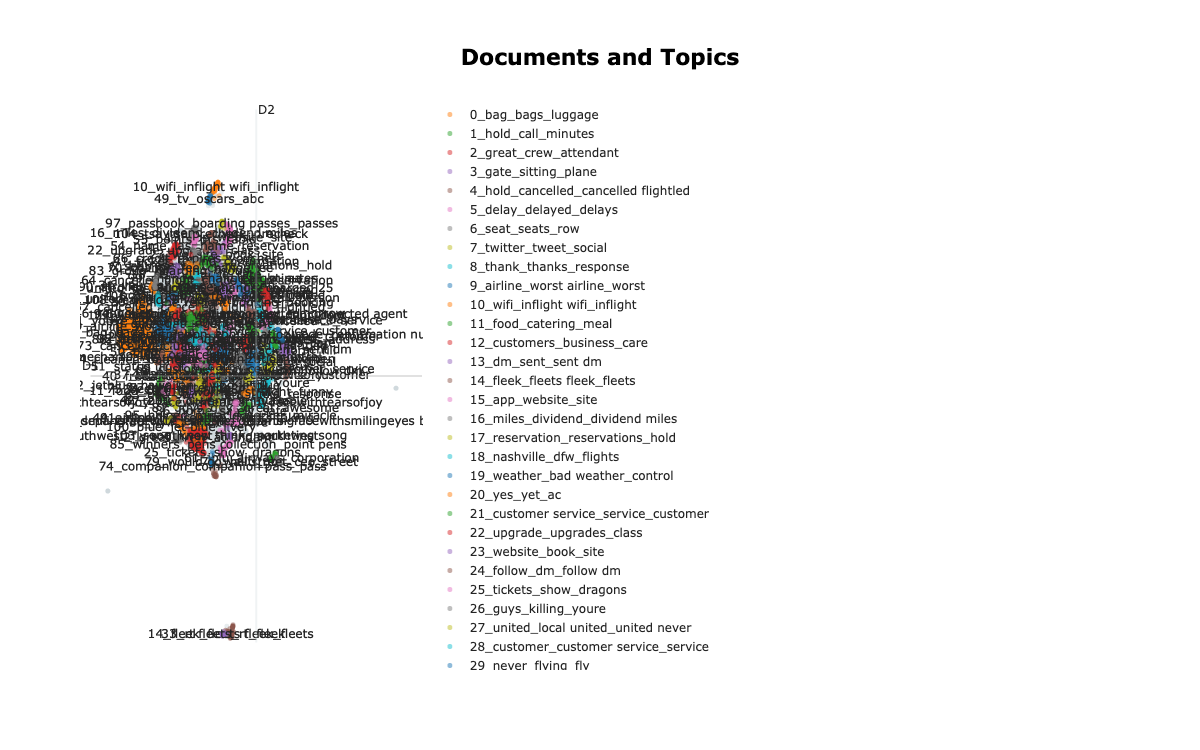

In [91]:
# Run the visualization with the original embeddings
# And viewing the original tweet text
bertmodel_mpnet.visualize_documents(docs=list(df.text), embeddings=embeddings_mpnet)

umap_vis = UMAP(
    n_neighbors=n_neighbors,
    n_components=2,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = umap_vis.fit_transform(embeddings_mpnet)
bertmodel_mpnet.visualize_documents(
    docs=list(df.text), reduced_embeddings=reduced_embeddings
)

### Visualise with wordclouds

In [92]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " " + str(topic))
    plt.show()

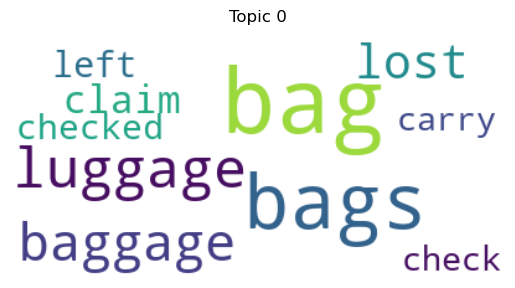

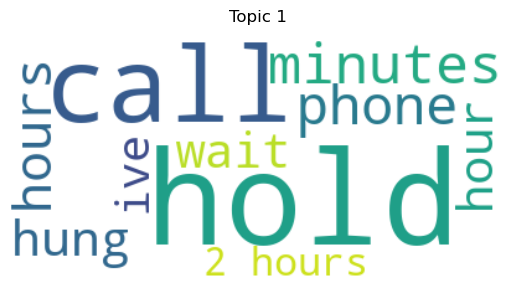

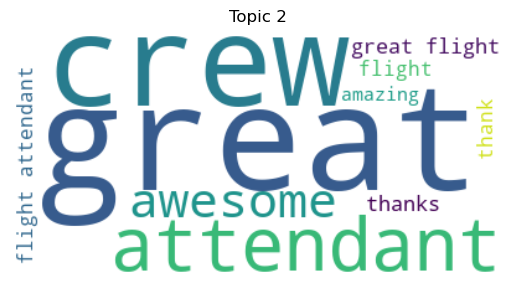

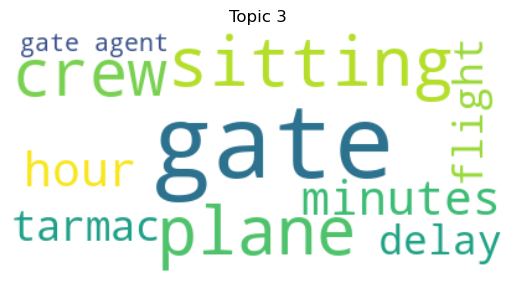

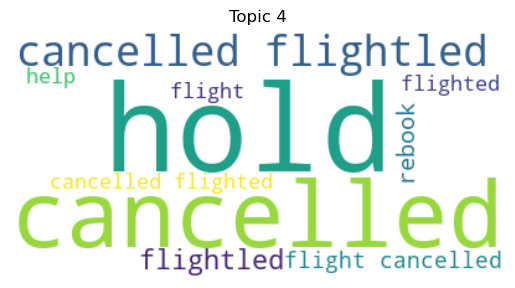

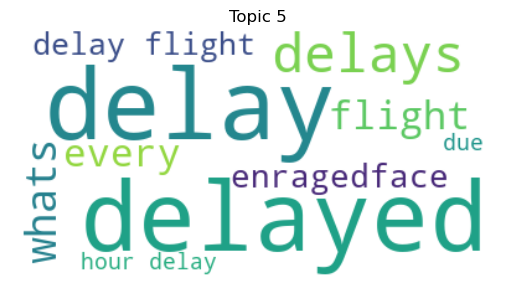

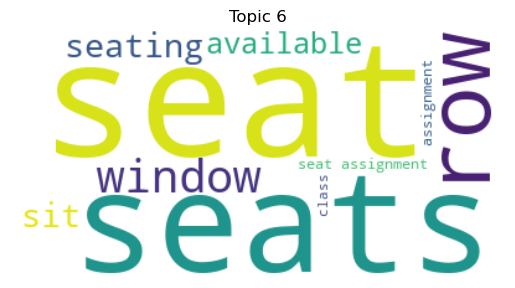

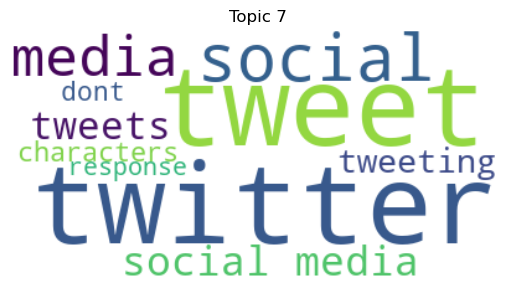

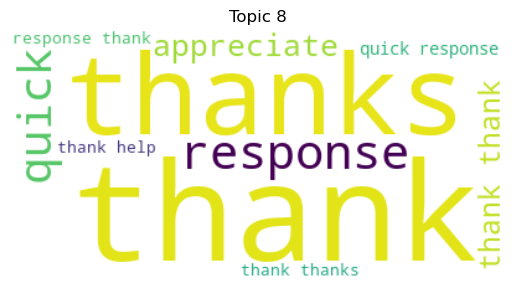

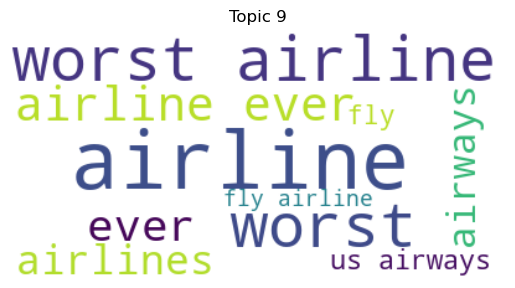

In [93]:
# Display the top 10 topics
for i in range(0, 10):
    create_wordcloud(bertmodel_mpnet, topic=i)

#### Save model:

In [94]:
# bertmodel_mpnet.save('../models/bertmodel_mpnet_3wordtweetdrop_delay_merge', save_embedding_model=True)

#### To load:

In [11]:
# bertmodel_mpnet = BERTopic.load("../models/bertmodel_mpnet_3wordtweetdrop")
bertmodel_mpnet = BERTopic.load("../models/bertmodel_mpnet_3wordtweetdrop_delay_merge")